# Test validity step 1 : $P(\eta | ...) \propto \eta^t \left( C_{approx}^{1/2} (C_{approx}^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) C_{approx}^{1/2} \right)^{-1} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import scipy
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.lax as jlx

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
# from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_SO_64_lower_noise import *
# from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


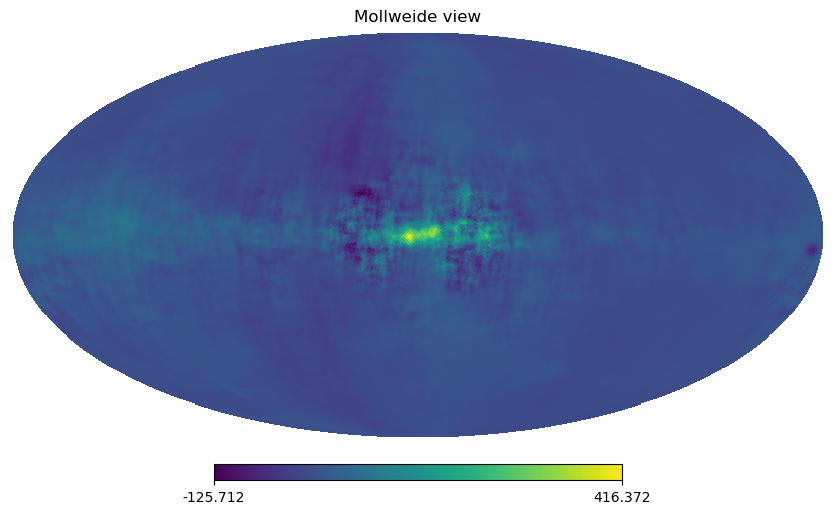

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:

working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v5/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

# path_toml_file = directory_toml_file + 'biased_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v1c.toml'

MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)


In [6]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

apod_mask = hp.ud_grade(hp.read_map(path_mask),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)
mask[apod_mask>0] = 1

mask = np.ones(MICMAC_sampler_obj.npix)

MICMAC_sampler_obj.mask = mask

In [7]:
%%time

freq_inverse_noise = MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))

nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,mask!=0] = np.repeat(freq_inverse_noise.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,nb_pixels_mask), order='C')


CPU times: user 35.9 ms, sys: 2.63 ms, total: 38.6 ms
Wall time: 37 ms


In [8]:
MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked

In [9]:
MICMAC_sampler_obj.freq_inverse_noise[:,:,mask==0]

array([], shape=(6, 6, 0), dtype=float64)

In [10]:
input_freq_maps, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask

# Re-Defining the data if needed
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]


theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]


c_ell_approx = np.zeros((3,MICMAC_sampler_obj.lmax+1))
c_ell_approx[0,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[1,:]

# Params mixing matrix
init_mixing_matrix_obj = micmac.InitMixingMatrix(MICMAC_sampler_obj.frequency_array, MICMAC_sampler_obj.number_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)
exact_params_mixing_matrix = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(MICMAC_sampler_obj.frequency_array, MICMAC_sampler_obj.number_components, exact_params_mixing_matrix, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(MICMAC_sampler_obj.freq_inverse_noise), mixing_matrix_sampled)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [11]:
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MICMAC_sampler_obj.lmin:,...]

In [12]:
red_cov_approx_matrix.shape

(127, 2, 2)

In [13]:
lmax = MICMAC_sampler_obj.lmax
n_iter = MICMAC_sampler_obj.n_iter
lmin = MICMAC_sampler_obj.lmin
nstokes = MICMAC_sampler_obj.nstokes
nside = MICMAC_sampler_obj.nside
number_frequencies = MICMAC_sampler_obj.number_frequencies
npix = MICMAC_sampler_obj.npix


In [14]:
# MICMAC_sampler_obj.limit_iter_cg = 200

In [15]:
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+10)
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+20)


In [16]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps = MICMAC_sampler_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 5.29 s, sys: 911 ms, total: 6.2 s
Wall time: 2.37 s


In [17]:
jitted_sampling_eta = jax.jit(MICMAC_sampler_obj.get_sampling_eta_v2, static_argnames=['suppress_low_modes'])

In [18]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 1.67 s, sys: 254 ms, total: 1.92 s
Wall time: 891 ms


In [19]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


CPU times: user 483 ms, sys: 68.6 ms, total: 551 ms
Wall time: 88 ms


In [20]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


In [21]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


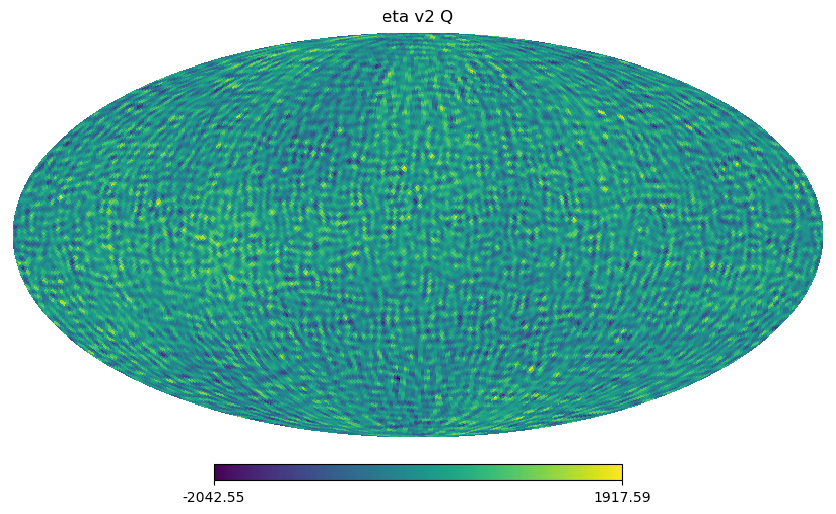

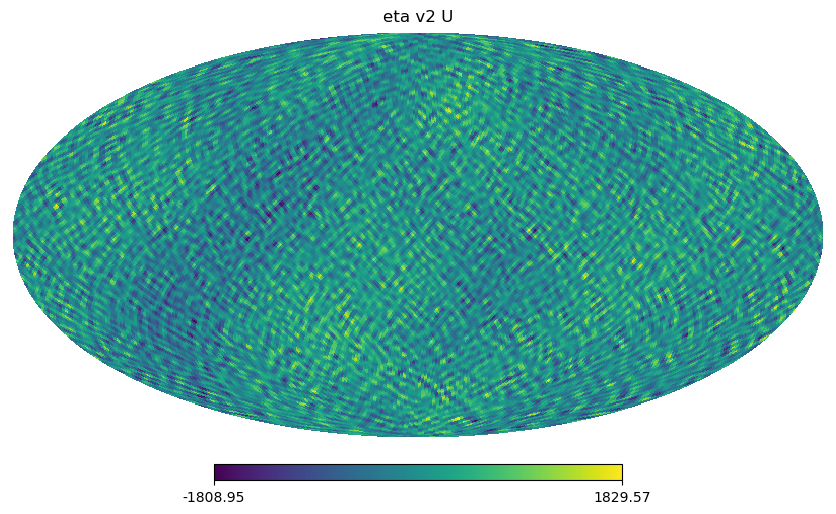

In [22]:
hp.mollview(eta_maps[0], title='eta v2 Q')
hp.mollview(eta_maps[1], title='eta v2 U')

In [23]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps_v1 = MICMAC_sampler_obj.get_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)

Recalculating x !
Recalculating y !
CPU times: user 1.18 s, sys: 303 ms, total: 1.48 s
Wall time: 293 ms


In [24]:
jitted_sampling_eta_v1 = jax.jit(MICMAC_sampler_obj.get_sampling_eta_v1, static_argnames=['suppress_low_modes'])

In [25]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps_v1 = jitted_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)

Recalculating x !
Recalculating y !
CPU times: user 1.08 s, sys: 152 ms, total: 1.23 s
Wall time: 658 ms


In [26]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps_v1 = jitted_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)

CPU times: user 223 ms, sys: 37.4 ms, total: 260 ms
Wall time: 79.1 ms


In [27]:
component_eta_map_prime = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, eta_maps_v1)[0]*hp.nside2resol(nside)


In [28]:
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+100)
new_eta_maps_v1 = MICMAC_sampler_obj.get_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG+1, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)
old_eta_maps_v1 = np.copy(eta_maps_v1)

Recalculating x !
Recalculating y !


In [29]:
eta_maps_extended = np.vstack([np.zeros_like(eta_maps[0]), eta_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [30]:
eta_maps_v1_extended = np.vstack([np.zeros_like(component_eta_map_prime[0]), component_eta_map_prime])
c_ells_eta_v1 = hp.anafast(eta_maps_v1_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [31]:
# covariance_noise = np.zeros_like(c_ell_approx)
# # covariance_noise[:nstokes,lmin:] = scipy.linalg.sqrtm(BtinvNB)[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]
# covariance_noise[:nstokes,lmin:] = BtinvNB[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]

_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, MICMAC_sampler_obj.lmax)[0,0,lmin:]

red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))


In [32]:
# analytical_eta_term = (c_ell_approx + covariance_noise)/np.sqrt(BtinvNB[0,0])

red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

red_cl_noise_harm_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cl_noise_harm)
red_cl_noise_harm_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cl_noise_harm))

analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)
analytical_eta_term_2 = np.zeros_like(c_ell_approx)
analytical_eta_term_2[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)


# analytical_eta_term_cov_v1 = np.einsum('lij,ljk,lkm->lim', red_cl_noise_harm_msqrt, red_cov_approx_matrix + red_cl_noise_harm, red_cl_noise_harm_msqrt)
analytical_eta_term_cov_v1 = np.copy(red_cov_approx_matrix + red_cl_noise_harm)
analytical_eta_term_v1 = np.zeros_like(c_ell_approx)
analytical_eta_term_v1[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov_v1)


In [33]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [34]:
fksy = mask.sum()/mask.size
# fksy = 1
print('fksy = ', fksy)

fksy =  1.0


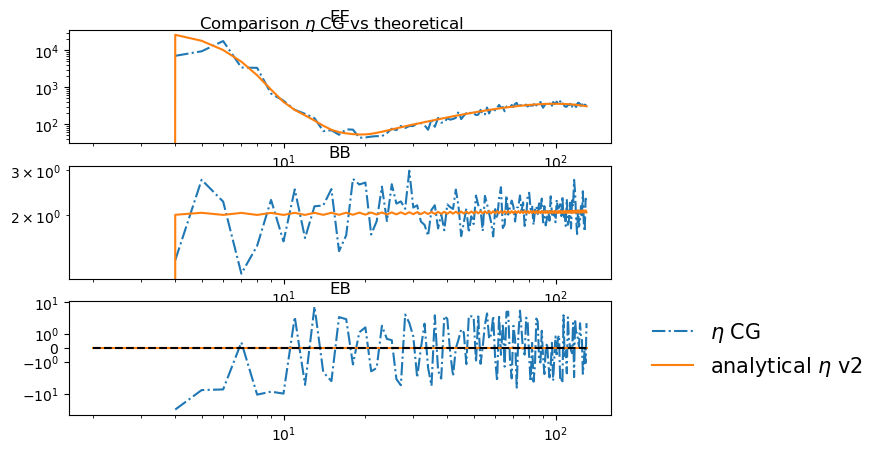

In [35]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:]/fksy, '-.', label=r"$\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel[j,:]/fksy, '-.', label=r"Overrelax $\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_v1[j,:]/fksy, '-.', label=r"$\eta$ v1 CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel_v1[j,:]/fksy, '-.', label=r"Overrelax v1 $\eta$ CG")

    # plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    plt.plot(ell_arange, analytical_eta_term_2[j,:], label=r"analytical $\eta$ v2")
    # plt.plot(ell_arange[lmin:], 1/_cl_noise_harm, '-.', label=r"$N_c$")
    # plt.plot(ell_arange[lmin:], 1/theoretical_r0_total[j,:], label='C_approx')
    # if j < nstokes:
    #     plt.plot([ell_arange[0], ell_arange[-1]], [1,1], '--', color='black')
    # plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')


plt.show()

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


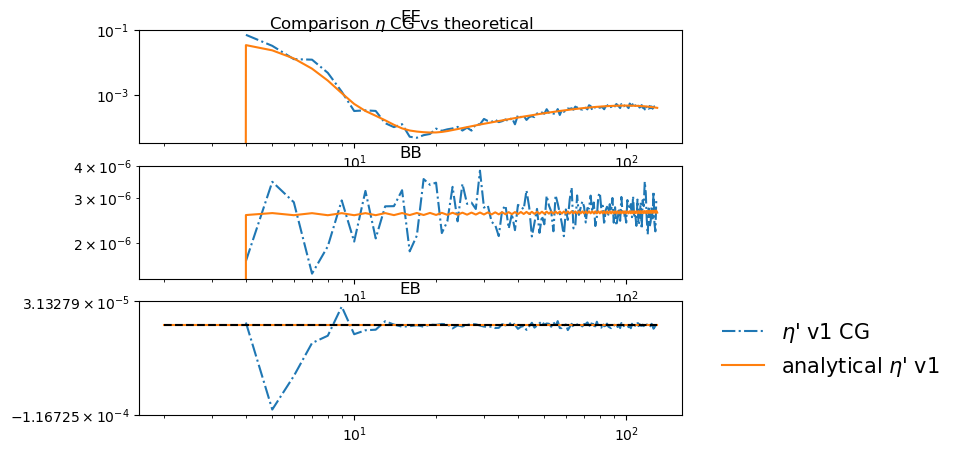

In [36]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    # plt.plot(ell_arange[lmin:], c_ells_eta[j,:]/fksy, '-.', label=r"$\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel[j,:]/fksy, '-.', label=r"Overrelax $\eta$ CG")
    plt.plot(ell_arange[lmin:], c_ells_eta_v1[j,:]/fksy, '-.', label=r"$\eta$' v1 CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel_v1[j,:]/fksy, '-.', label=r"Overrelax v1 $\eta$ CG")

    # plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    # plt.plot(ell_arange, analytical_eta_term_2[j,:], label=r"analytical $\eta$ v2")
    plt.plot(ell_arange, analytical_eta_term_v1[j,:], label=r"analytical $\eta$' v1")
    # plt.plot(ell_arange[lmin:], 1/_cl_noise_harm, '-.', label=r"$N_c$")
    # plt.plot(ell_arange[lmin:], 1/theoretical_r0_total[j,:], label='C_approx')
    # if j < nstokes:
    #     plt.plot([ell_arange[0], ell_arange[-1]], [1,1], '--', color='black')
    # plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')


plt.show()

In [37]:
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/hp.nside2resol(nside)**2)

product_1 = np.einsum('cfp,ckp->fkp', BtinvN_sqrt, BtinvNB)#*N_c_inv

product_2 = np.einsum('ckp,kfp->cfp', BtinvNB, BtinvN_sqrt)

In [38]:
print(np.einsum('fkp,cfp->ckp', product_1, product_2)[:,:,100]/BtinvNB[0,0,100])
print(np.einsum('cfp,fkp->ckp', product_2, product_1)[:,:,100]/BtinvNB[0,0,100])


[[  1.          -4.72711814  -3.02899876]
 [ -4.72711814 132.70599784  10.36831334]
 [ -3.02899876  10.36831334  21.6719946 ]]
[[  1.          -4.72711814  -3.02899876]
 [ -4.72711814 132.70599784  10.36831334]
 [ -3.02899876  10.36831334  21.6719946 ]]


In [39]:
test_map_random_x = jax.random.normal(jax_key_PNRG, shape=(number_frequencies,nstokes,npix))

test_noise = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, test_map_random_x)[0]

test_noise_extended = np.vstack([np.zeros_like(test_noise[0]), test_noise])
cl_noise_test = hp.anafast(test_noise_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

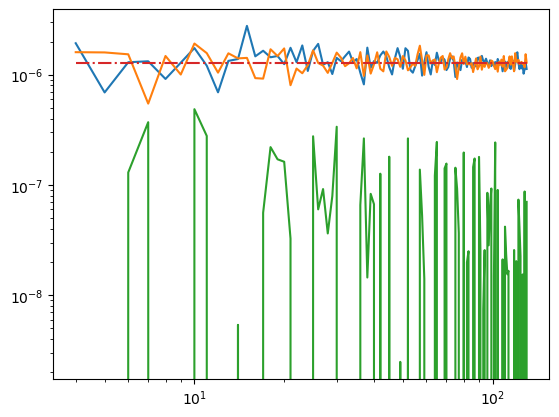

In [40]:
plt.plot(ell_arange[lmin:], cl_noise_test.T)
plt.plot(ell_arange[lmin:], _cl_noise_harm, '-.', label=r"$N_c$")
plt.loglog()
plt.show()

In [41]:
test_map_random_y = jax.random.normal(jax_key_PNRG, shape=(number_frequencies,nstokes,npix))

N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/hp.nside2resol(nside)**2)

test_noise_2 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, test_map_random_y)[0]*N_c_inv

test_noise_2_extended = np.vstack([np.zeros_like(test_noise_2[0]), test_noise_2])
cl_noise_test_2 = hp.anafast(test_noise_2_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

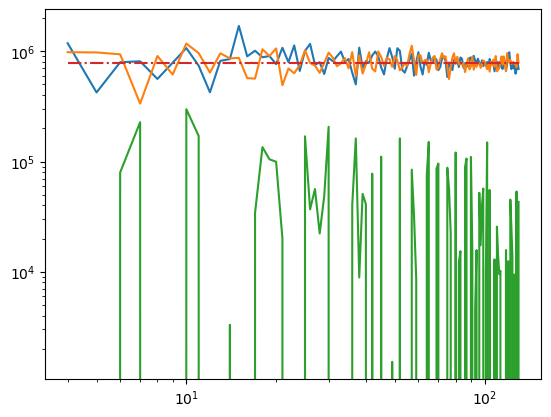

In [42]:
plt.plot(ell_arange[lmin:], cl_noise_test_2.T)
plt.plot(ell_arange[lmin:], 1/_cl_noise_harm, '-.', label=r"$1/N_c$")
plt.loglog()
plt.show()

In [43]:
test_map_random_x = jax.random.normal(jax_key_PNRG, shape=(number_frequencies,nstokes,npix))

N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/hp.nside2resol(nside)**2)

test_noise_3 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, test_map_random_x)[0]*N_c_inv

test_noise_3_extended = np.vstack([np.zeros_like(test_noise_3[0]), test_noise_2])
cl_noise_test_3 = hp.anafast(test_noise_3_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

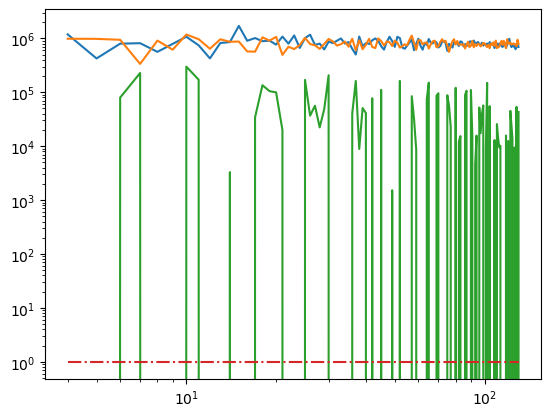

In [44]:
plt.plot(ell_arange[lmin:], cl_noise_test_3.T)
plt.plot(ell_arange[lmin:], np.ones_like(ell_arange[lmin:]), '-.', label=r"$1/N_c$")
plt.loglog()
plt.show()

# Test func

In [45]:
def partial_get_conditional_proba_correction_likelihood_JAX_v2(complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    red_cov_approx_matrix_msqrt = jnp.linalg.pinv(get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix))

    ## Computation of C_approx^{-1/2} eta
    component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)

    operator_harmonic = jnp.linalg.pinv(red_cov_approx_matrix)
    operator_pixel = N_c_inv
    
    first_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), operator_harmonic, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    def second_term_left(x):
        return x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*operator_pixel

    func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    initial_guess = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
    right_member = jnp.copy(component_eta_maps_2)
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)

    ## Computation of C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    component_eta_maps_3 = maps_x_red_covariance_cell_JAX(inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    return component_eta_maps_3

    # And finally eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # second_term_complete = jnp.einsum('sk,sk', component_eta_maps, component_eta_maps_3)
    second_term_complete = jnp.einsum('sp,p,sp', component_eta_maps, MICMAC_sampler_obj.mask, component_eta_maps_3)
    return -(-0 + second_term_complete)/2.*jhp.nside2resol(MICMAC_sampler_obj.nside)**2

def partial_get_conditional_proba_correction_likelihood_JAX_v2b(complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    
    red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)

    ## Computation of C_approx^{-1/2} eta
    # component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)

    operator_harmonic = jnp.linalg.pinv(red_cov_approx_matrix)
    operator_pixel = N_c_inv
    
    first_part_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    
    def second_part_left(x):
        return x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*operator_pixel

    third_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

    # func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()
    func_left_term = lambda x : x.ravel() + third_part_term_left(second_part_left(first_part_left(x))).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    initial_guess = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
    right_member = jnp.copy(component_eta_maps)
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)

    return inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)
    ## Computation of C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # component_eta_maps_3 = maps_x_red_covariance_cell_JAX(inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    # And finally eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # second_term_complete = jnp.einsum('sk,sk', component_eta_maps, inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
    second_term_complete = jnp.einsum('sp,p,sp', component_eta_maps, MICMAC_sampler_obj.mask, inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
    return -(-0 + second_term_complete)/2.*jhp.nside2resol(MICMAC_sampler_obj.nside)**2


In [46]:
def test_get_conditional_proba_correction_likelihood_JAX_v2(complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    red_cov_approx_matrix_msqrt = jnp.linalg.pinv(get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix))

    ## Computation of C_approx^{-1/2} eta
    component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)

    operator_harmonic = jnp.linalg.pinv(red_cov_approx_matrix)
    operator_pixel = N_c_inv
    
    first_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), operator_harmonic, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    def second_term_left(x):
        return x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*operator_pixel

    func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    initial_guess = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
    right_member = jnp.copy(component_eta_maps_2)
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)

    ## Computation of C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    component_eta_maps_3 = maps_x_red_covariance_cell_JAX(inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    # And finally eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # second_term_complete = jnp.einsum('sk,sk', component_eta_maps, component_eta_maps_3)
    second_term_complete = jnp.einsum('sp,p,sp', component_eta_maps, MICMAC_sampler_obj.mask, component_eta_maps_3)
    return -(-0 + second_term_complete)/2.*jhp.nside2resol(MICMAC_sampler_obj.nside)**2

def test_get_conditional_proba_correction_likelihood_JAX_v2b(complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    
    red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)

    ## Computation of C_approx^{-1/2} eta
    # component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)

    operator_harmonic = jnp.linalg.pinv(red_cov_approx_matrix)
    operator_pixel = N_c_inv
    
    first_part_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    
    def second_part_left(x):
        return x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*operator_pixel

    third_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

    # func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()
    func_left_term = lambda x : x.ravel() + third_part_term_left(second_part_left(first_part_left(x))).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    initial_guess = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
    right_member = jnp.copy(component_eta_maps)
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)

    ## Computation of C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # component_eta_maps_3 = maps_x_red_covariance_cell_JAX(inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    # And finally eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # second_term_complete = jnp.einsum('sk,sk', component_eta_maps, inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
    second_term_complete = jnp.einsum('sp,p,sp', component_eta_maps, MICMAC_sampler_obj.mask, inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
    return -(-0 + second_term_complete)/2.*jhp.nside2resol(MICMAC_sampler_obj.nside)**2


In [47]:
# true_mask = mask
# fake_mask = np.ones_like(mask)

# MICMAC_sampler_obj.mask = true_mask

In [66]:
%%time
partial_term_1 = partial_get_conditional_proba_correction_likelihood_JAX_v2(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix)

CPU times: user 4.13 s, sys: 1.04 s, total: 5.16 s
Wall time: 994 ms


In [67]:
%%time
partial_term_2 = partial_get_conditional_proba_correction_likelihood_JAX_v2b(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix)

CPU times: user 59.3 s, sys: 7.09 s, total: 1min 6s
Wall time: 10.8 s


In [77]:
log_proba_partial_term_1 = -np.einsum('sp,p,sp', eta_maps, MICMAC_sampler_obj.mask, partial_term_1)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2/2
log_proba_partial_term_2 = -np.einsum('sp,p,sp', eta_maps, MICMAC_sampler_obj.mask, partial_term_2)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2/2


In [85]:
def get_eta_term_back(partial_proba_term, complete_mixing_matrix, red_cov_approx_matrix):
    invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2

    red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[mask!=0].set(1/invBtinvNB[0,0,mask!=0]/jhp.nside2resol(nside)**2)

    func_1st_term = lambda x : maps_x_red_covariance_cell_JAX(x.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    func_2nd_term_1 = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), jnp.linalg.pinv(red_cov_approx_matrix), nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    func_2nd_term_2 = lambda x : x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*N_c_inv

    func_2nd_term = lambda x : (func_2nd_term_1(x) + func_2nd_term_2(x)).ravel()

    total_func = lambda x : func_1st_term(func_2nd_term(func_1st_term(x))).ravel()

    return total_func(partial_proba_term.ravel()).reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)



In [86]:
eta_from_partial_1 = get_eta_term_back(partial_term_1, mixing_matrix_sampled, red_cov_approx_matrix)
eta_from_partial_2 = get_eta_term_back(partial_term_2, mixing_matrix_sampled, red_cov_approx_matrix)

(3, 3, 49152)
(3, 3, 49152)


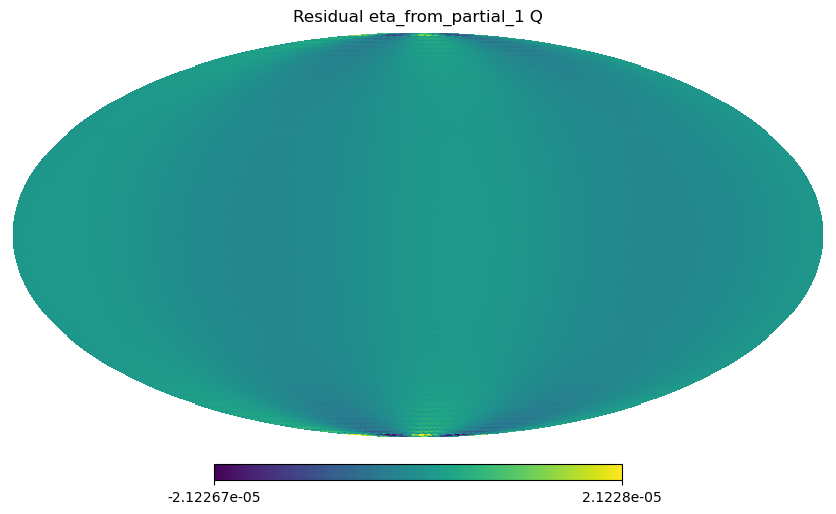

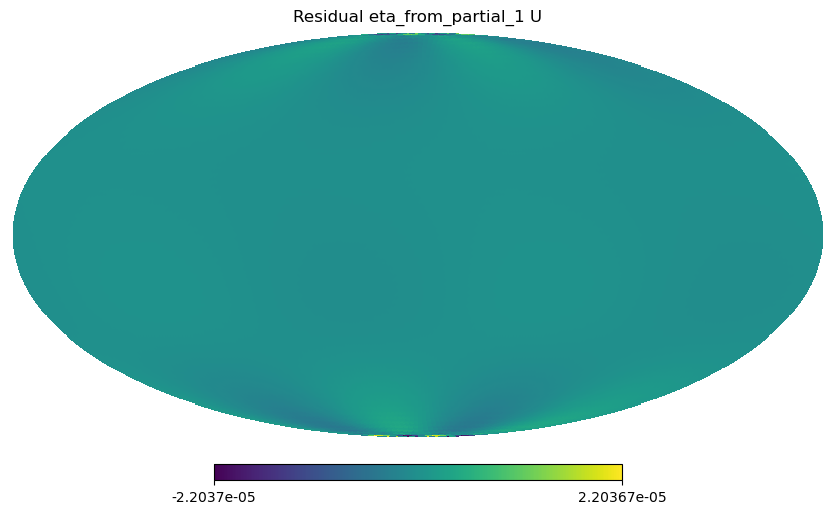

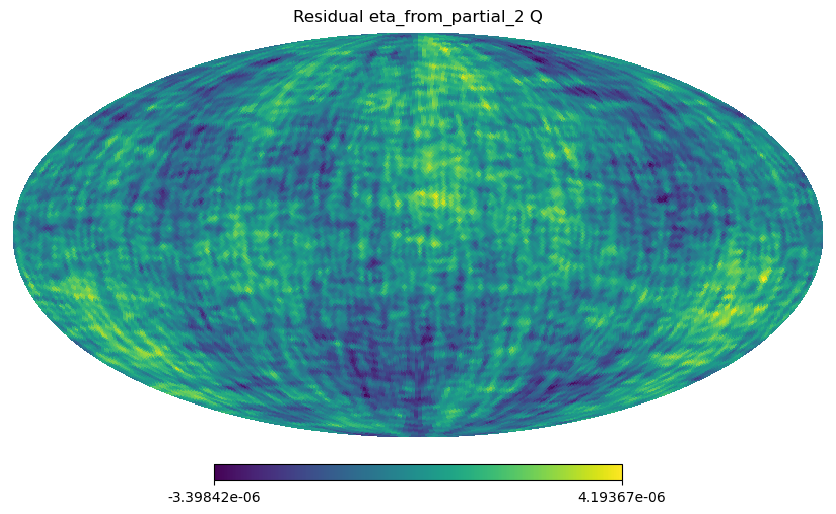

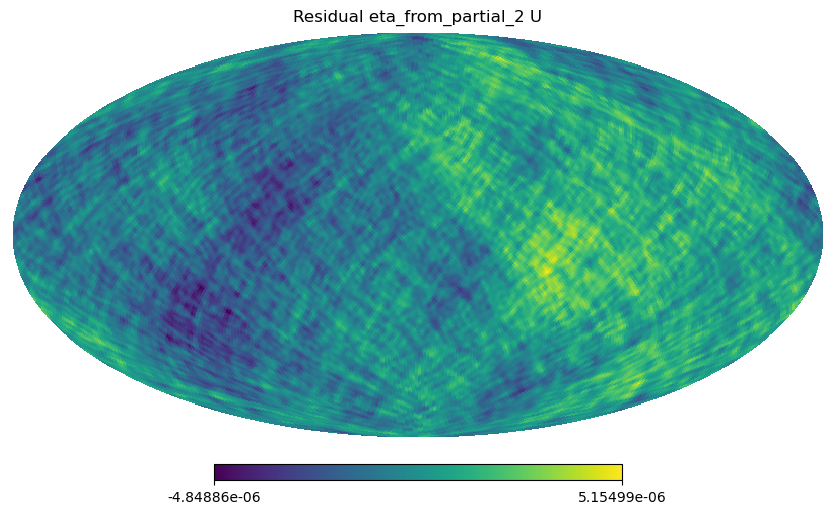

In [89]:
hp.mollview(eta_from_partial_1[0]-eta_maps[0], title='Residual eta_from_partial_1 Q')
hp.mollview(eta_from_partial_1[1]-eta_maps[1], title='Residual eta_from_partial_1 U')
hp.mollview(eta_from_partial_2[0]-eta_maps[0], title='Residual eta_from_partial_2 Q')
hp.mollview(eta_from_partial_2[1]-eta_maps[1], title='Residual eta_from_partial_2 U')

# Test step 4

In [48]:
MICMAC_sampler_obj.limit_iter_cg = 200

In [49]:
%%time
log_proba_1 = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v2(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix)

CPU times: user 6.39 s, sys: 1.49 s, total: 7.88 s
Wall time: 1.86 s


In [50]:
%%time
log_proba_2 = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v2b(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix)

CPU times: user 58.1 s, sys: 6.87 s, total: 1min 4s
Wall time: 10.5 s


In [51]:
%%time
log_proba_t1 = test_get_conditional_proba_correction_likelihood_JAX_v2(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix)

CPU times: user 5.42 s, sys: 1.37 s, total: 6.79 s
Wall time: 998 ms


In [52]:
%%time
log_proba_t2 = test_get_conditional_proba_correction_likelihood_JAX_v2b(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix)

CPU times: user 57.6 s, sys: 6.42 s, total: 1min 4s
Wall time: 9.6 s


In [78]:
print("v2a", log_proba_1)
print("v2b", log_proba_2)
print("tv2a", log_proba_t1)
print("tv2b", log_proba_t2)

print("partial v2a", log_proba_partial_term_1)
print("partial v2b", log_proba_partial_term_2)

v2a -6.316204460176775
v2b -6.3162044602347605
tv2a -6.3162044601767775
tv2b -6.316204460234778
partial v2a -6.3162044601767295
partial v2b -6.31620446023476


In [79]:
print("v2a", log_proba_1)
print("v2b", log_proba_2)
print("tv2a", log_proba_t1)
print("tv2b", log_proba_t2)

print("partial v2a", log_proba_partial_term_1)
print("partial v2b", log_proba_partial_term_2)

v2a -6.316204460176775
v2b -6.3162044602347605
tv2a -6.3162044601767775
tv2b -6.316204460234778
partial v2a -6.3162044601767295
partial v2b -6.31620446023476


In [55]:
eta_maps_v1_from_v2 = np.einsum('cfp,cp,sp->fsp', BtinvN_sqrt, BtinvNB[:,0,...], eta_maps)*hp.nside2resol(nside)/np.sqrt(BtinvNB[0,0,0]*hp.nside2resol(nside)**2)

In [56]:
%%time
log_proba_v1a = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v1(mixing_matrix_sampled, eta_maps_v1_from_v2, red_cov_approx_matrix)

CPU times: user 42 s, sys: 6.5 s, total: 48.5 s
Wall time: 7.83 s


In [57]:
%%time
log_proba_v1ab = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v1b(mixing_matrix_sampled, eta_maps_v1_from_v2, red_cov_approx_matrix)

CPU times: user 29.6 s, sys: 3.48 s, total: 33 s
Wall time: 4.99 s


In [58]:
%%time
log_proba_v1ac = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v1c(mixing_matrix_sampled, eta_maps_v1_from_v2, red_cov_approx_matrix)

CPU times: user 35.6 s, sys: 4.91 s, total: 40.5 s
Wall time: 6.19 s


In [59]:
%%time
log_proba_v1b = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v1(mixing_matrix_sampled, eta_maps_v1, red_cov_approx_matrix)

CPU times: user 42 s, sys: 6.6 s, total: 48.6 s
Wall time: 7.37 s


In [60]:
eta_maps_from_v1 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, eta_maps_v1)[0]*hp.nside2resol(nside)/np.sqrt(BtinvNB[0,0,0]*hp.nside2resol(nside)**2)

In [61]:
%%time
log_proba_1b = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v2(mixing_matrix_sampled, eta_maps_from_v1, red_cov_approx_matrix)

CPU times: user 5.04 s, sys: 1.14 s, total: 6.18 s
Wall time: 1.02 s


In [62]:
MICMAC_sampler_obj.mask[MICMAC_sampler_obj.mask==0]

array([], dtype=float64)

In [63]:
print("v2a", log_proba_1)
print("v2b", log_proba_2)
print("v1a", log_proba_v1a)
# print("v1ab", log_proba_v1ab)
# print("v1ac", log_proba_v1ac)

print("v2c", log_proba_1b)
print("v1b", log_proba_v1b)

v2a -6.316204460176775
v2b -6.3162044602347605
v1a -16684.2514764331
v2c -6.324250574447114
v1b -49221.37812620153


In [64]:
log_proba_v1a/log_proba_1b#/number_frequencies/number_frequencies

Array(2638.13890358, dtype=float64)

In [65]:
log_proba_v1a

Array(-16684.25147643, dtype=float64)